In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='0'

import torch
from fastai.vision import *
import superRes.fid_score as fs
from superRes.dataset import *

from superRes.inception import InceptionV3

In [2]:
help(fs)

Help on module superRes.fid_score in superRes:

NAME
    superRes.fid_score - Calculates the Frechet Inception Distance (FID) to evalulate GANs

DESCRIPTION
    The FID metric calculates the distance between two distributions of images.
    Typically, we have summary statistics (mean & covariance matrix) of one
    of these distributions, while the 2nd distribution is given by a GAN.
    
    When run as a stand-alone program, it compares the distribution of
    images that are stored as PNG/JPEG at a specified location with a
    distribution given by summary statistics (in pickle format).
    
    The FID is calculated by assuming that X_1 and X_2 are the activations of
    the pool_3 layer of the inception net for generated samples and real world
    samples respectively.
    
    See --help to see further details.
    
    Code apapted from https://github.com/bioinf-jku/TTUR to use PyTorch instead
    of Tensorflow
    
    Copyright 2018 Institute of Bioinformatics, JKU Linz
    


In [3]:
path = untar_data(URLs.PETS)

path_fullRes = path/'images'
path_sampleImagesFullRes = path/'sampleImagesFullRes' # 10 img sample fullRes
path_sampleImagesLowRes = path/'sampleImagesLowRes'# same 10 img sample but low res

In [4]:
low = ImageList.from_folder(path_sampleImagesLowRes)
full = ImageList.from_folder(path_sampleImagesFullRes)
print(low[0].shape)
print(full[0].shape)

torch.Size([3, 256, 382])
torch.Size([3, 256, 382])


In [23]:
def get_databunch(
    sz: int,
    bs: int,
    crappy_path: Path,
    good_path: Path,
    random_seed: int = 42,
    keep_pct: float = 1.0,
    num_workers: int = 8,
    xtra_tfms=[],
) -> ImageDataBunch:

    src = (
        ImageImageList.from_folder(crappy_path)
        .split_none()
    )

    data = (
        src.label_from_func(lambda x: good_path / x.relative_to(crappy_path))
        .transform(
            get_transforms(
                max_zoom=1.
            ),
            size=sz,
            tfm_y=True,
        )
        .databunch(bs=bs, num_workers=num_workers, no_check=True)
    )

    data.c = 3
    return data

In [6]:
def get_data(bs:int, sz:int, keep_pct:float):
    return get_databunch(sz=sz, bs=bs, crappy_path=path_sampleImagesLowRes, 
                         good_path=path_sampleImagesFullRes, 
                         random_seed=None, keep_pct=keep_pct)

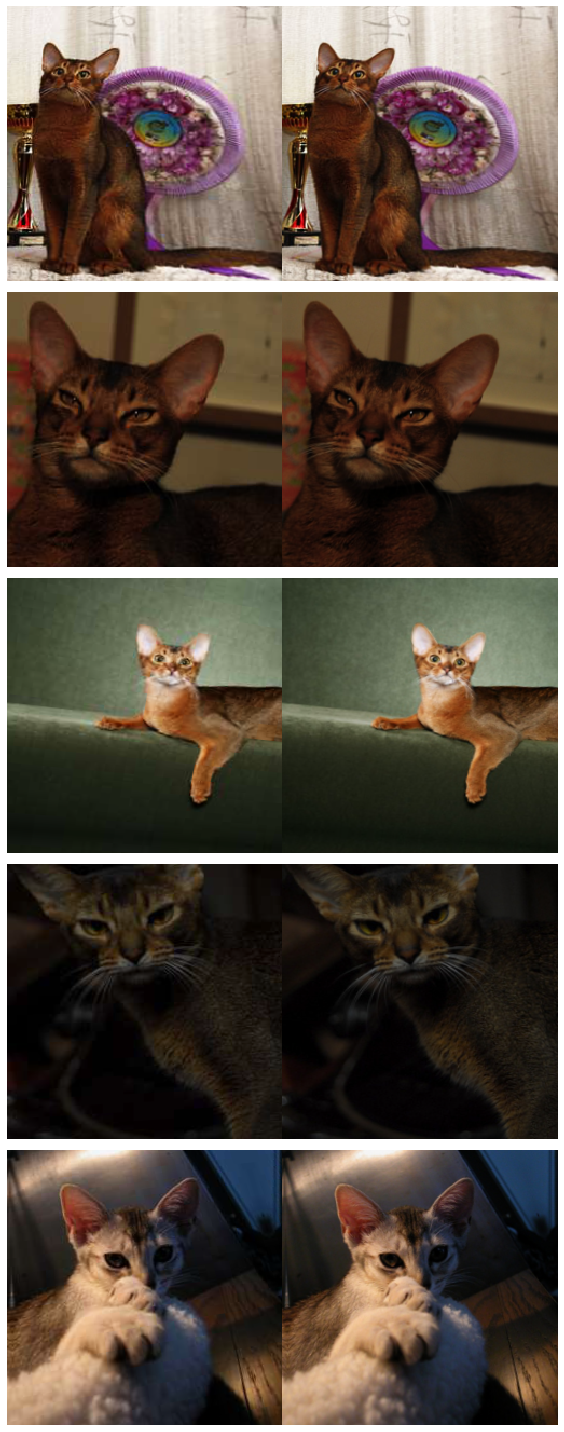

In [24]:
data = get_data(bs=10, sz=256, keep_pct=1.)
data.show_batch()
x, y = data.one_batch()

In [8]:
paths = [str(path_sampleImagesFullRes), str(path_sampleImagesLowRes)]
paths

['/data/students_home/fmameli/.fastai/data/oxford-iiit-pet/sampleImagesFullRes',
 '/data/students_home/fmameli/.fastai/data/oxford-iiit-pet/sampleImagesLowRes']

In [9]:
def calculate_fid_given_paths(paths, batch_size, cuda, dims):
    """Calculates the FID of two paths"""
    for p in paths:
        if not os.path.exists(p):
            raise RuntimeError('Invalid path: %s' % p)

    block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[dims]

    model = InceptionV3([block_idx])
    if cuda:
        model.cuda()
    
    # m vector size dims 
    # s matrix size dims x dims
    m1, s1 = fs._compute_statistics_of_path(paths[0], model, batch_size,
                                         dims, cuda)
    
    m2, s2 = fs._compute_statistics_of_path(paths[1], model, batch_size,
                                         dims, cuda)
    
    fid_value = fs.calculate_frechet_distance(m1, s1, m2, s2)

    return fid_value, m1, s1

In [10]:
f, m, s = calculate_fid_given_paths(paths, 1, True, 2048)
# print(m.size)
# print(s.size)
print(f)

 60%|██████    | 6/10 [00:00<00:00, 50.43it/s]

pred size is :(10, 2048)


100%|██████████| 10/10 [00:00<00:00, 50.99it/s]


pred size is :(10, 2048)
38.92548737404513


In [11]:
def get_activations(imgs, model, dims=2048, cuda=False, verbose=False):
    model.eval()    
    
    n_imgs = len(imgs)

    pred_arr = np.empty((n_imgs, dims))

    if cuda:
        imgs = imgs.cuda()
    pred = model(imgs)[0]

    # If model output is not scalar, apply global spatial average pooling.
    # This happens if you choose a dimensionality not equal 2048.
    if pred.shape[2] != 1 or pred.shape[3] != 1:
        pred = adaptive_avg_pool2d(pred, output_size=(1, 1))

    pred_arr = pred.cpu().data.numpy().reshape(n_imgs, -1)

    if verbose:
        print(' done')

    return pred_arr

In [12]:
block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[2048]
model = InceptionV3([block_idx])

get_activations(x, model)

array([[0.457618, 0.508423, 0.359057, 0.009261, ..., 0.105865, 0.10797 , 0.398024, 0.04009 ],
       [0.380331, 0.581848, 0.213633, 0.015325, ..., 0.052002, 0.415708, 0.698841, 0.436633],
       [0.722224, 0.315277, 0.674387, 0.034406, ..., 0.615363, 0.526306, 0.157599, 0.530219],
       [0.590785, 0.277772, 0.321379, 0.090293, ..., 0.140426, 0.045686, 0.085819, 0.389149],
       ...,
       [0.158629, 0.482363, 0.69632 , 0.053106, ..., 0.017491, 0.109118, 0.753537, 0.350921],
       [0.210307, 0.128263, 0.225485, 0.024032, ..., 0.164547, 0.401789, 0.269336, 0.123012],
       [0.652881, 0.25363 , 0.664566, 0.01062 , ..., 0.202665, 0.331894, 0.102762, 0.615176],
       [0.632609, 0.143168, 0.357546, 0.025232, ..., 0.017956, 0.129599, 0.015948, 0.610356]], dtype=float32)

In [13]:
def calculate_activation_statistics(img_tensor, model,
                                    dims=2048, cuda=False, verbose=False):
    act = get_activations(img_tensor, model, dims, cuda, verbose)
    mu = np.mean(act, axis=0)
    sigma = np.cov(act, rowvar=False)
    return mu, sigma

In [14]:
def calculate_fid_given_imgs(x, y, cuda, dims):
    """Calculates the FID of two paths"""

    block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[dims]

    model = InceptionV3([block_idx])
    if cuda:
        model.cuda()
    # m vector size dims 
    # s matrix size dims x dims
    m1, s1 = calculate_activation_statistics(x, model, dims, cuda)
    
    m2, s2 = calculate_activation_statistics(y, model, dims, cuda)
    
    fid_value = fs.calculate_frechet_distance(m1, s1, m2, s2)

    return fid_value

In [25]:
calculate_fid_given_imgs(x, y, True, 2048)

39.36832829659147